In [4]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import copy
import geopandas as gp

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)

# local functions
import diff_nmf
import grid_search
import data_generator
import nmf
from diff_nmf import diff_nmf
from grid_search import gridSearcher
from data_generator import *
from nmf import nmf
from graph_utility import graph_util

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**In this experiment we use real COVID-19 case data for a collection of contiguous US States (found in covid_dataset/us_state/) to see if Diffusion-NMF might recover trends not seen by NMF.** 

### Graphing preliminaries

In [5]:
sns.set_palette("Set2")
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 1

# custom hex list for colormap
h_list = ["ffb950","ffad33","ff931f","ff7e33","fa5e1f","ec3f13","b81702","a50104","8e0103","7a0103"]
# get custom features from graph_util
graph_tool = graph_util()
linestyles_dict = graph_tool.linestyles()
my_pal = graph_tool.custom_map(h_list)

### The Data

In [6]:
# importing
dataset = pd.read_csv(os.path.join(par, "covid_dataset/us_state/dataset.csv"), index_col = 0).astype(np.float64)
laplacian = pd.read_csv(os.path.join(par, "covid_dataset/us_state/laplacian.csv"), index_col = 0)
population = pd.read_csv(os.path.join(par, "covid_dataset/us_state/population.csv"), index_col = 0)
population.loc[:, 'population_estimate'] = population.loc[:, 'population_estimate'].astype(np.float64)

# json file with geographic info for each state -- required for graphing
state_map = os.path.join(par, 'covid_dataset/us_state/geography.json')

NOTE: For the purposes of this experiment I am not including Alaska, Hawaii, or Puerto Rico in the data. This is simply because our current description of diffusion is very much dependent on adjacency between locations. Because it is unclear of how these regions should be included in the adjacency graph and because they share no land borders with other regions in the data, we have chosen to simply leave them out for now. We hope that in the future we will be able to create better diffusion processes or adjacency graphs so that they may be included. 

In [9]:
dataset = dataset.iloc[:630,:]
dataset = dataset.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 1)

laplacian = laplacian.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 1)
laplacian = laplacian.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 0)

**Data Cleaning/Preparation:** We perform a location-wise normalization of data with the help of separate population data. Specifically each location's set of case counts is divided the location's estimated population. This ensures that both densely and non-densely populated areas are given (to the best of our ability) equal representation within the data. 

We also use an isotonic regression on each of the columns of the data to fix any inconsistencies. Sometimes it happens that a location might falsely report a decline in cumulative cases (which shouldn't be possible given that cases can't erase themselves). We have not investigated reasons for why this may happen, but have taken precaution to ensure that these be corrected so as not to affect the output of our algorithm. More specifically, for each location an isotonic regression fits a new line (not necessarily linear or continuous) which not only matches the data points which are already increasing, but also makes sure to correct any decreasing data points, giving them new values that enforce the strictly increasing constraint. Any location whose data does not contain errors is not changed. 

In [10]:
# normalize the data set by population (i.e. divide each column by that states population)
for col in dataset.columns:
    dataset.loc[:,col] /= population.loc[population.name == col, 'population_estimate'].item() 
    
# For further preparation, perfrom isotonic regression on each of the columns
# COVID-19 cumulative case counts should be always increasing from day to day, but because this is real data there are often errors in reporting
# Isotonic regression simply fixes these small errors giving nicer wave-like case counts
# IF a location does not contain any error, nothing is changed.

dataset = iso_regression(dataset)

### Grid Search

**Given the computational cost of a grid search I have chosen to exclude it from the notebook. What is shown is a pre-saved image of the results. I have tried to make the process simple and easy to follow by including the grid_search.py file in the repository.** To find the best set of parameters for which diffusion-nmf performs best we chose to try a range of different rank and beta (spread parameter) combinations. We choose final values by analyzing the trends shown in the graph and finding parameter combinations that give small relative error. 

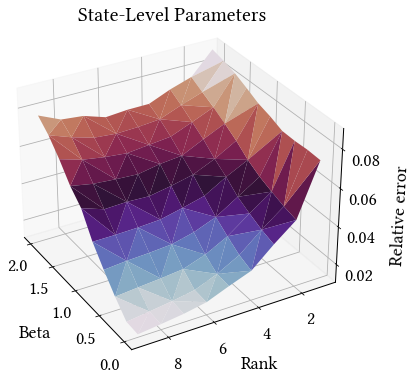

In [11]:
state_grid = pd.read_csv(os.path.join(par, "covid_dataset/us_state/grid_search_results/diff_rank_beta_error.csv"))
fig = plt.figure(figsize = (10,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(state_grid['beta'], state_grid['rank'], state_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

ax.xaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("State-Level Parameters", fontsize = 20)
ax.view_init(30,150)
ax.dist = 9

For this example and for many of the others that we show, it is difficult to discern a correct parameter choice by analyzing this graph alone. Much of the heavy lifting must be done by experimentation and intuition. For our purposes we choice to use the parameter combination rank = 5, beta = 1. The rank parameter, at least, shows a nice trend in the figure above. Right around the value of 5, the error drops more rapidly than it does as rank continues to increase. We chose to use this value because its at the "elbow" of the curve seen. The beta (spread) parameter is more difficult to choose for. Though values around 0 do show small error, we did our best to make sure we stayed away from 0 without adding on to much error to out solution. This is because as beta approaches 0 (as diffusion/spread goes to nothing) the solution approaches the NMF solution. We'd like to stay away from that, which does constrain our solution, but allows us the opportunity to justify our hypothesis of a diffusion process.

### Results:

In [12]:
# prepare parameters
rank = 5
beta = 1
K = np.linalg.inv(np.identity(len(laplacian)) + beta * laplacian.to_numpy())

# diffusion nmf (takes a few minutes or so)
dNMF = diff_nmf(n_components = rank, kernel = K, n_iter = 200000  , tol = 1e-10)
X,V = dNMF.fit_transform(dataset)

In [13]:
# regular nmf for comparison
nmfer = nmf(rank, n_iter = 200000, tol = 1e-10)
W,H = nmfer.fit_transform(dataset)

Max iterations reached, increase to converge on given tolerance


In [15]:
#rescaling
X,V = rescale(X,V)
X = pd.DataFrame(X, index = dataset.index)
V = pd.DataFrame(V, columns = dataset.columns)

W,H = rescale(W,H)
W = pd.DataFrame(W, index = dataset.index)
H = pd.DataFrame(H, columns = dataset.columns)

**Note that for side by side comparison later you'd need to re order the waves here so that similar waves are compared together.** For best comparison please see the figures included in our paper, but feel free to use whats given below to re-order it for yourself. Simply change the order of waves by changing the re-order list below. I wish I had a nice method to automate this, but haven't found one yet. My tactic is to order them by time-wise appearance of waves. The very first wave to see some sort of peak (even if its very small) is wave 0, next is wave 1, etc. Note that the outputs from NMF and DNMF must be ordered separately.

In [18]:
# RE-order for better presentation
X.columns = ["Wave " + str(i) for i in range(rank)]
W.columns = ["Wave " + str(i) for i in range(rank)]
V.index = ["Wave " + str(i) for i in range(rank)]
H.index = ["Wave " + str(i) for i in range(rank)]

standard = X.columns
reorder = ['Wave 4', 'Wave 1', 'Wave 2', 'Wave 0', 'Wave 3']
X = X[reorder]
X.columns = standard
V = V.reindex(reorder)
V.index = standard 

# RE-order for better presentation
standard = W.columns
reorder = ['Wave 3', 'Wave 1', 'Wave 4', 'Wave 0', 'Wave 2']
W = W[reorder]
W.columns = standard
H = H.reindex(reorder)
H.index = standard 

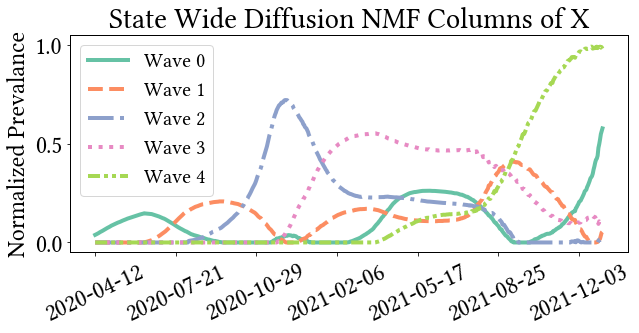

In [19]:
plt.rcParams["font.size"] = 24
plt.rcParams["legend.fontsize"] = 20
X.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(X.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()
plt.xticks(rotation = 25)
plt.ylabel("Normalized Prevalance")
plt.title("State Wide Diffusion NMF Columns of X")
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_diffX.pdf',  bbox_inches = "tight")
plt.show()

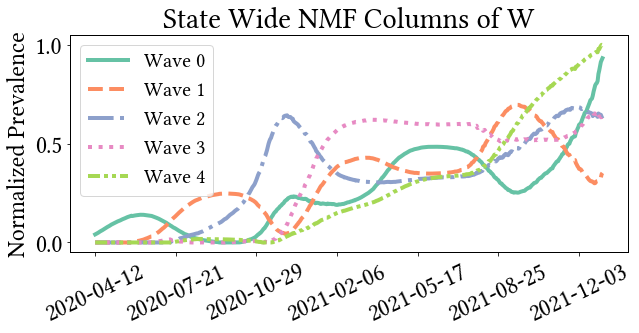

In [20]:
plt.rcParams["font.size"] = 24
W.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(W.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()

plt.xticks(rotation = 25)
plt.ylabel("Normalized Prevalence")
plt.title("State Wide NMF Columns of W")
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper2/figures/state_nmfX.pdf',  bbox_inches = "tight")
plt.show()

The two figures above show that both NMF and D-NMF capture similar waves with only slight differences. It might be noted that peaks within curves of the D-NMF solution are a bit sharper, but the real advantage to D-NMF comes from analyzing the V matrix (shown row-by-row in map form in the figures below). 

Text(0.5, 1.0, 'Row 1 of V (D-NMF)')

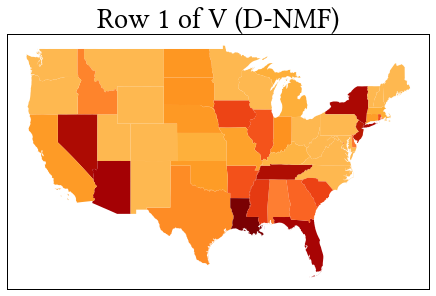

In [21]:
plt.rcParams["font.size"] = 24
stateMap = gp.read_file(state_map)

# CHANGE PARAMETER TO SEE DIFFERENT MAPS:
row_num = 1

val_col1 = []
for i in stateMap["NAME"]:
    try:
        val_col1.append(V.loc["Wave " + str(row_num),i])
    except:
        pass
        val_col1.append(np.nan)


stateMap['val1'] = val_col1

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

stateMap.plot(column='val1',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("Row " + str(row_num) + " of V (D-NMF)")

#fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_V' + str(row_num) + '.pdf', bbox_inches = "tight")

Text(0.5, 1.0, 'Row 1 of H (NMF)')

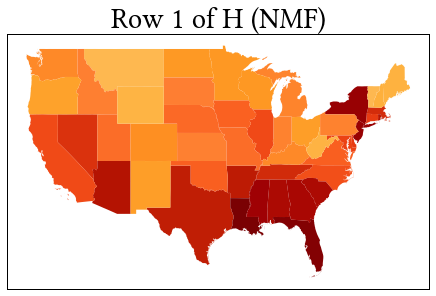

In [22]:
# CHANGE PARAMETER TO SEE DIFFERENT MAPS:
row_num = 1

H_col = []
for i in stateMap["NAME"]:
    try:
        H_col.append(H.loc["Wave " + str(row_num),i])
    except:
        H_col.append(np.nan)

stateMap['val'] = H_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))
stateMap.plot(column='val',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("Row " + str(row_num) + " of H (NMF)")

#fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_H' + str(row_num) + '.pdf', bbox_inches = "tight")

Changing the row_num parameter in the two cells above allows you to view maps which correspond to other waves or rows of V/H. For most it is clear that the D-NMF solution does a better job of highlighting origin points or centers of diffusion within the data. Whereas NMF solutions have coefficients which are very similar to each other, there are sharper contrasts between certain states and their neighbors in the D-NMF solutions. If our hypotheses are correct, these states colored in darker red are locations from which their respective wave either originated or had a larger than normal effect. 

### Error Checking

The following was ran through the process of another grid search. However this time the beta was kept at a constant value of 1. This was done so that a comparison with the error seen with NMF would be allowed. 

In [23]:
state_diff_error = pd.read_csv(os.path.join(par, "covid_dataset/us_state/grid_search_results/diff_rank_error.csv"))
state_nmf_error = state_grid = pd.read_csv(os.path.join(par, "covid_dataset/us_state/grid_search_results/nmf_rank_error.csv"))

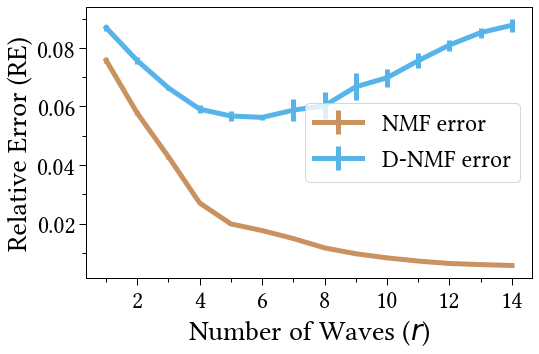

In [24]:
c_pal = sns.color_palette("colorblind", 10)
plt.rcParams['legend.fontsize'] = 24
ranks = list(range(1,15))
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(ranks, state_nmf_error["relative error"], state_nmf_error["std error"], label = "NMF error", linewidth = 5, color = c_pal[5])
ax.errorbar(ranks, state_diff_error["relative error"], state_diff_error["std error"], label = "D-NMF error", linewidth = 5, color = c_pal[9])

ax.set_xlabel(r"Number of Waves ($r$)", fontsize = 28)
ax.set_ylabel("Relative Error (RE)", fontsize = 28)
plt.legend()
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_error.pdf', bbox_inches = "tight")

Seen above is a comparison between NMF and D-NMF for recovery error. More specifically, we solved both NMF and D-NMF using the same input data but varied the rank parameter. After obtaining solutions we took the products of W and H (from NMF) and the products of X, V, and K (from D-NMF) and compared them to the original data. The difference between the original and the recovered solution is what is shown in the graph above. Note that NMF consistently outperforms D-NMF. This was to be expected given that D-NMF is essentially a further constraint built upon NMF. 